In [1]:
'''
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install numpy
'''


import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg 
plt.rcParams['figure.figsize'] = [15,15]


#plt.rcParams['figure.figsize'] = [15,15]

w: (2280, 1080, 3)
g: (2280, 1080)
[23, 123, 213, 338, 481, 558, 593, 696, 1056, 1211, 1412, 1596, 1810, 1899, 2120, 2153, 2208]
[56, 167, 321, 420, 536, 590, 600, 943, 1142, 1241, 1452, 1626, 1842, 1941, 2150, 2157, 2263]


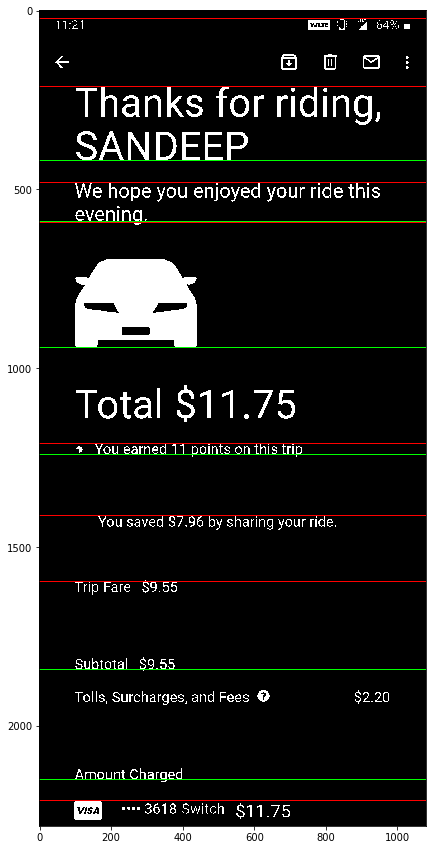

In [40]:
warped = mpimg.imread('uber_bill.jpg')
print("w:",warped.shape)
#plt.imshow(warped)
gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
print("g:",gray.shape)
#plt.imshow(gray)#binary
ret,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY_INV)
ret2,thresh2 = cv2.threshold(gray,150,255,cv2.THRESH_BINARY)
#plt.imshow(thresh)
#dilation
kernel = np.ones((2,2), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)


hist = cv2.reduce(img_dilation,1, cv2.REDUCE_AVG)
#print(hist)
th = 2
H,W = warped.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

img_lineseg = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for y in uppers:
    cv2.line(img_lineseg, (0,y), (W, y), (255,0,0), 1)

for y in lowers:
    cv2.line(img_lineseg, (0,y), (W, y), (0,255,0), 1)
plt.imshow(img_lineseg)
print(uppers)
print(lowers)


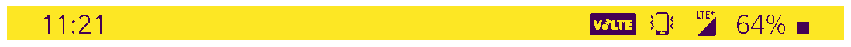

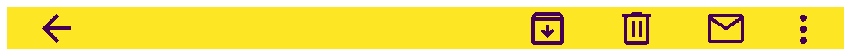

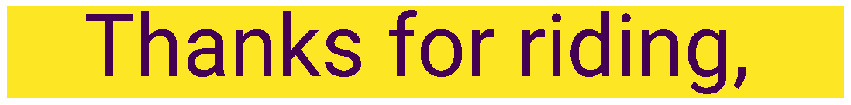

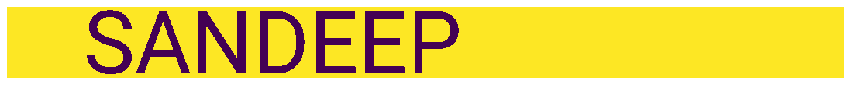

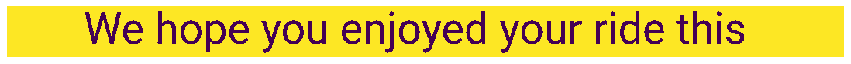

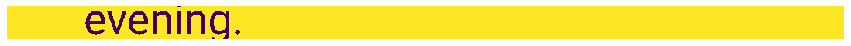

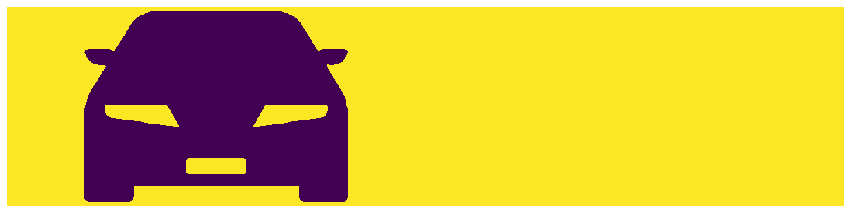

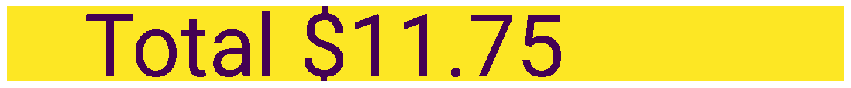

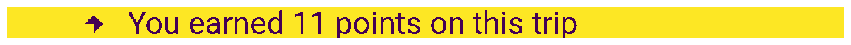

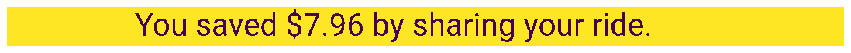

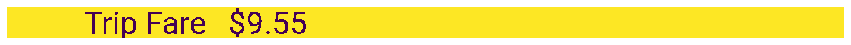

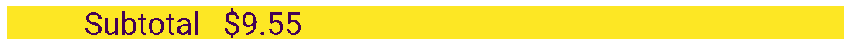

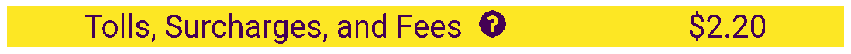

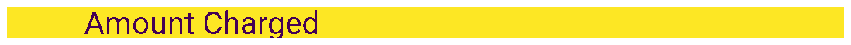

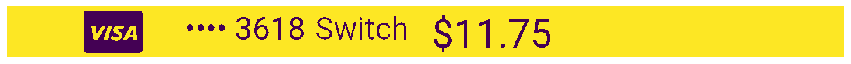

In [41]:
plt.rcParams['figure.figsize'] = [15,15]

line_images_array = []
img_lines = cv2.cvtColor(thresh2, cv2.COLOR_GRAY2BGR)

for i in range(len(uppers)):
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(thresh2[uppers[i]-5:lowers[i]+5,:])
    ax.axis('off')
    line_images_array.append(thresh2[uppers[i]-5:lowers[i]+5,:])

line_images_array2 = line_images_array[1:]



In [22]:
import difflib
import importlib
import math
import random
import string
import gluonnlp as nlp
import leven
import mxnet as mx
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm
from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch
import ocr.utils.denoiser_utils
import ocr.utils.beam_search
importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator
importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch
from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding
from mxnet import nd
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

[nltk_data] Downloading package perluniprops to
[nltk_data]     /Users/skundala/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


/Users/skundala/miniconda3/lib/python3.7/site-packages/gluonnlp/data/transforms.py:236: UserWarning: sacremoses is not installed. To install sacremoses, use pip install -U sacremoses Now try NLTKMosesTokenizer using NLTK ...
  warnings.warn('sacremoses is not installed. '
/Users/skundala/miniconda3/lib/python3.7/site-packages/gluonnlp/data/transforms.py:417: UserWarning: sacremoses is not installed. To install sacremoses, use pip install -U sacremoses Now try NLTKMosesDetokenizer using NLTK ...
  warnings.warn('sacremoses is not installed. '


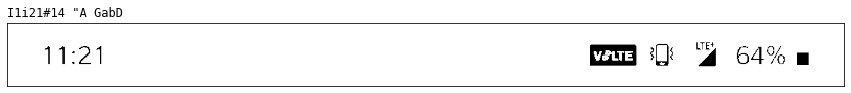

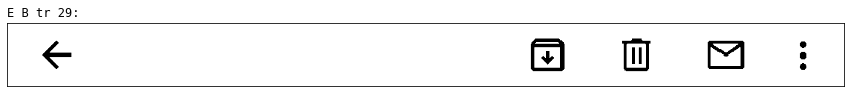

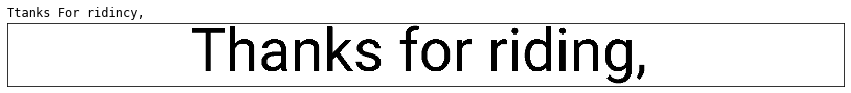

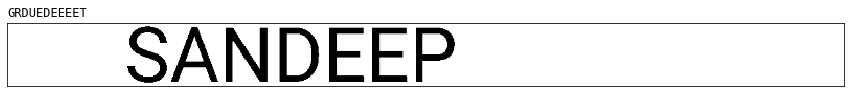

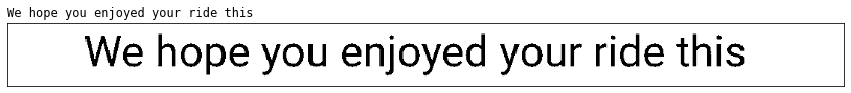

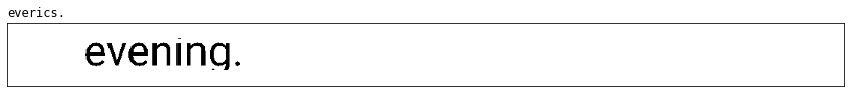

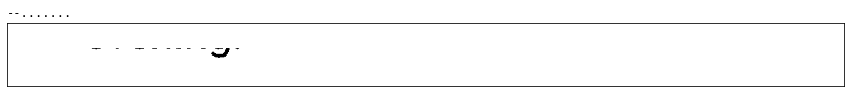

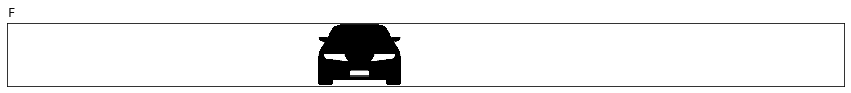

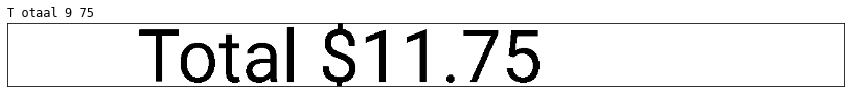

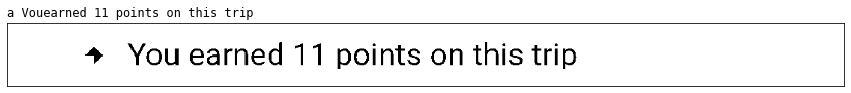

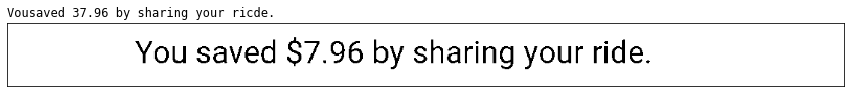

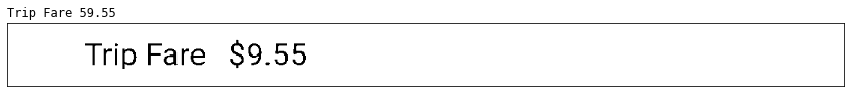

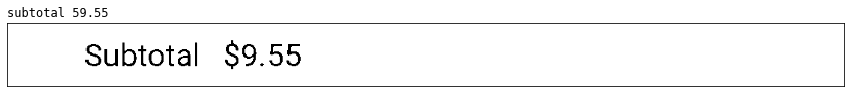

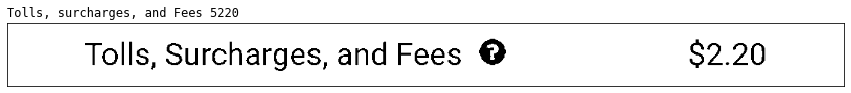

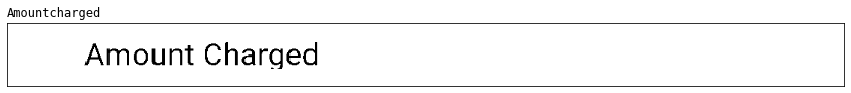

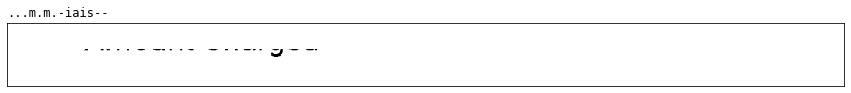

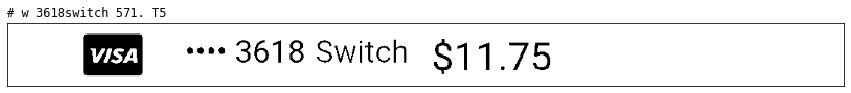

In [43]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

def resize_image(image, desired_size):
    ''' Helper function to resize an image while keeping the aspect ratio.
    Parameter
    ---------

    image: np.array
        The image to be resized.

    desired_size: (int, int)
        The (height, width) of the resized image

    Return
    ------

    image: np.array
        The image of size = desired_size

    bounding box: (int, int, int, int)
        (x, y, w, h) in percentages of the resized image of the original
    '''
    size = image.shape[:2]
    #print(image.shape)
    #print('resize_image size[0]',size[0])
    #print('resize_image size[1]',size[1])
    #print('resize_image desired_size[0]',desired_size[0])
    #print('resize_image desired_size[1]',desired_size[1])
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[0]
        ratio_h = float(desired_size[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape

    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = image[0][0]
    if color < 230:
        color = 230
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
               (image.shape[0] - bottom - top)/image.shape[0])
    image[image > 230] = 255
    return image, crop_bb

def handwriting_recognition_transform(image, line_image_size):
    '''
    Resize and normalise the image to be fed into the network.
    '''
    #print(line_image_size[0])
    image, _ = resize_image(image, line_image_size)
    image = mx.nd.array(image)/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    image = image.expand_dims(0).expand_dims(0)
    return image
'''
line_image_size = (50, 500)
#print(line_image_size[0])
character_probs = []
for line_image in line_images_array:
    form_character_prob = []
    line_image = handwriting_recognition_transform(line_image, line_image_size)
    line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
    form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)


'''
def transform(image, label=None):
    #This function resizes the input image and converts so that it could be fed into the network.
    #Furthermore, the label (text) is one-hot encoded.
   
    image = np.expand_dims(image, axis=0).astype(np.float32)
    image = image/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    
    return image


for l_image in line_images_array:
    #fig = plt.figure()  # create a figure object
    #ax = fig.add_subplot(1, 1, 1)
    #plt.imshow(l_image)
    
    #print(l_image.shape)
    
    #l_image = l_image.mean(axis=2)
    #plt.imshow(l_image)
    l_image = handwriting_recognition_transform(l_image, (60,800))
    
    l_image = nd.array(l_image)
    l_image = l_image.as_in_context(ctx)
    
    

    output = handwriting_line_recognition_net(l_image)
    predictions = output.softmax().topk(axis=2).asnumpy()
    decoded_prediction_text = decoder_handwriting(predictions)[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')
    
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    ax.imshow(l_image.asnumpy().squeeze(), cmap='Greys_r')
    ax.set_title(decoded_prediction_text,
                    fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
    ax.tick_params(axis='both',       
                       which='both',      
                       bottom=False,      
                       top=False,         
                       left=False,
                       right=False,
                       labelleft=False,
                       labelbottom=False)
                     